# Numerical Optimization of an AR(2)-GARCH(1,1) Gaussian Likelihood Function

In this exercise, you will estimate the parameters of an AR(2)-GARCH(1,1) model using **maximum likelihood**.

---

### Context

Prices and returns are observed. However, the (ex-ante) return variance $Var_t(r_{t+1})$ is **not** observable.

Estimating $Var_t(r_{t+1})$ is essential in both academia and industry — particularly for:

- **Risk management**
- **Asset allocation**

Ordinary Least Squares (OLS) cannot be used to estimate this time-varying variance, but **Maximum Likelihood Estimation (MLE)** provides a powerful alternative.

To apply MLE, we:

1. Specify a model (in this case: AR(2)-GARCH(1,1))
2. Write down the **likelihood function**
3. Implement an algorithm to **maximize the likelihood** (or minimize the negative log-likelihood)

This notebook walks you through each of these steps.


### Get daily return data

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from arch import arch_model
import math
import matplotlib.pyplot as plt
import scipy.optimize as sco
from statsmodels.tsa.arima_model import ARMA

In [2]:
df = pd.read_csv("r_ES50_d_cleaned_realized.csv", index_col="Date")

In [3]:
df

,ADS.DE,AI.PA,ALV.DE,ASML.AS,CS.PA,BBVA.MC,SAN.MC,BAS.DE,BAYN.DE,BMW.DE,...,SU.PA,SIE.DE,TEF.MC,FP.PA,URW.AS,UNA.AS,DG.PA,VIV.PA,VOW.DE,1/N
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.023996,-0.009332,-0.004736,-0.100229,-0.015385,-0.022708,-0.024598,-0.038939,-0.026907,-0.019987,...,-0.042903,-0.034424,-0.047851,-0.025479,-0.000945,0.021525,0.022467,-0.024392,-0.037946,-0.022821
2000-01-06,0.041964,0.069408,0.040316,-0.072511,-0.007782,0.006279,0.000000,0.003755,0.003403,-0.003249,...,0.049442,-0.012306,0.000874,-0.029461,0.029561,0.036187,0.032790,-0.011798,-0.004413,0.006099
2000-01-07,-0.013793,-0.012318,0.027432,0.072005,0.030772,0.006240,0.043328,0.040197,0.040830,-0.001810,...,0.018089,0.039441,0.000873,0.004971,-0.006212,0.014364,0.031750,0.008088,0.028438,0.023823
2000-01-10,0.015025,-0.035451,0.005750,0.069533,0.000000,-0.016227,-0.008872,0.004390,0.035670,0.039081,...,-0.016786,0.057803,0.029700,0.000826,0.010789,-0.011506,-0.042558,0.086030,0.002800,0.009664
2000-01-11,-0.009347,-0.009217,-0.009157,0.012224,-0.022990,-0.020279,-0.034456,-0.045421,-0.030031,-0.003490,...,-0.039170,0.006872,0.000849,0.007404,0.004556,-0.012549,0.042558,0.018587,0.015536,-0.004634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,0.009711,0.005137,0.015274,0.000777,0.008762,0.012781,0.024750,0.001007,-0.029875,0.015893,...,0.005816,0.008457,0.023065,0.007984,0.021723,-0.001435,0.011280,0.008270,0.018981,0.008056
2020-06-26,-0.021232,-0.005930,-0.015387,0.006192,-0.002372,-0.024058,-0.031093,-0.020328,-0.016924,-0.023218,...,0.007634,-0.002746,-0.020212,-0.001848,-0.052789,0.006543,-0.008571,-0.003039,-0.009094,-0.007704
2020-06-29,-0.006891,0.011041,0.012395,-0.005571,0.005061,0.027633,0.039511,0.029043,0.001646,0.016714,...,0.013272,0.018099,0.024855,0.002463,0.011663,-0.025595,0.017311,0.008658,0.010486,0.012619


In [4]:
r_t = df['ADS.DE'] #adidas returns

<Axes: xlabel='Date'>

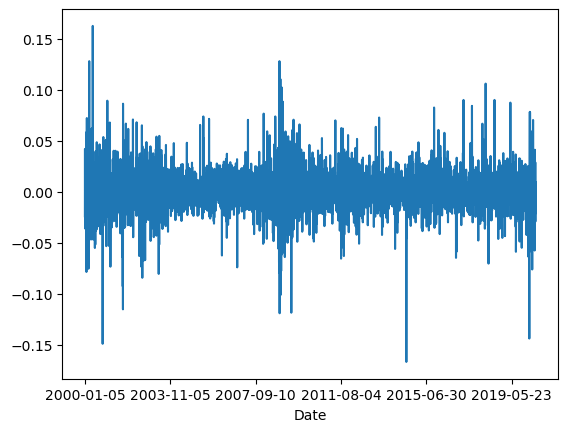

In [7]:
r_t.plot()

### Model

Previous exercise found the optimal AR-lag is 2 for Adidas daily returns. Hence, in the following we are going to use an AR(2) to model the mean equation and additionally add a GARCH(1,1) to model the conditional variance. 

The Conditionally Gaussian Log Likelhood Function (not part of FDS) is shown here: 

    
\begin{align*}
ln L([\phi_0, \phi_1, \phi_2, \alpha_0, \alpha_1, \beta_1]\; | \; [r_1, ..., r_T]) := & \sum_{t=3}^T \left( -\frac{1}{2} \ln (2\pi) - \frac{1}{2} \ln ( \sigma^2_{t-1} ) - \frac{1}{2} \, \frac{\epsilon^2_t}{ \sigma^2_{t-1}  } \right)   \\ \\
\epsilon_t & \equiv r_t - \phi_0 - \phi_1 r_{t-1} - \phi_2 r_{t-2}, \\ \\
\sigma^2_{t-1} & \equiv  \alpha_0 + \alpha_1 \, \times \, \epsilon^2_{t-1} \, + \,  \beta_1 \, \times \, \sigma^2_{t-2} \\ \\
&  \sigma^2_{1} \equiv \frac{\alpha_0}{ 1 - \alpha_1 -  \beta_1}.
\end{align*}  

**Handmade MLE**

In [12]:

# MLE estimation of AR(2)-GARCH(1, 1) model
# -------------------------------------------------

def garch_1_1_variance(alpha_0, alpha_1, beta_1, epsilon_t):
    sigma2_tmin1 = np.zeros(epsilon_t.shape[0] - 1)
    sigma2_tmin1[0] = alpha_0 / (1 - alpha_1 - beta_1)
    
    for t in range(1, len(sigma2_tmin1)):
        sigma2_tmin1[t] = alpha_0 + alpha_1 * epsilon_t[t]**2 + beta_1 * sigma2_tmin1[t-1]
    
    return sigma2_tmin1
    

def Neg_loglikelihood_ar2_Garch11(parameters):
    phi_0 = parameters[0]
    phi_1 = parameters[1]
    phi_2 = parameters[2]
    alpha_0 = parameters[3]
    alpha_1 = parameters[4]
    beta_1 = parameters[5]
  
    mean_ar2_prediction_t = phi_0 + phi_1 * r_t.iloc[1:-1].values + phi_2 * r_t.iloc[:-2].values
    eps_t = r_t.iloc[2:].values - mean_ar2_prediction_t
    var_garch11_tmin1 = garch_1_1_variance(alpha_0, alpha_1, beta_1, eps_t)
            
    lnL = np.sum(-0.5 * np.log(2. * np.pi * var_garch11_tmin1) - 0.5 * (eps_t[1:])**2 / (var_garch11_tmin1))
    
    return -1. * lnL

**Smart MLE Starting Values: OLS AR(2) and Rule of Thumb for Vol**_


In [14]:
def lagged_data(data, lags):
    nobs = data.shape[0]
    y_lag = data[lags:nobs]
    x_lag = np.matrix(np.zeros((nobs-lags)*lags).reshape((nobs-lags),lags))
    for i in range(1, lags+1):
        x_lag[:,i-1] = data[(lags-i):(nobs-i)].reshape(nobs-lags, 1)
        
    return x_lag, y_lag

x,y = lagged_data(r_t.values, 2)

In [15]:
# OLS:  r_t = const + beta1 * r_(t-1) + beta2 * r_(t-2) + eps

x = sm.add_constant(x)
ar_start=sm.OLS(y, x).fit()

In [16]:
phi_start_params = ar_start.params
phi0_start = phi_start_params[0]
phi1_start = phi_start_params[1]
phi2_start = phi_start_params[2]

In [17]:
# start values for Adidas return variance
alpha0_start = 0.0001
alpha1_start = 0.15
beta1_start = 0.8

**Execute handmade MLE**

In [19]:
ar_garch_params_start = [phi0_start, phi1_start, phi2_start, alpha0_start, alpha1_start, beta1_start] #starting values
ar_garch_params = sco.minimize(Neg_loglikelihood_ar2_Garch11, ar_garch_params_start, method='Nelder-Mead') #fit mle model

In [20]:
ar_garch_params

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -13798.791081338484
             x: [ 1.208e-03  3.179e-02 -4.829e-02  8.045e-06  4.217e-02
                  9.349e-01]
           nit: 392
          nfev: 615
 final_simplex: (array([[ 1.208e-03,  3.179e-02, ...,  4.217e-02,
                         9.349e-01],
                       [ 1.209e-03,  3.170e-02, ...,  4.217e-02,
                         9.349e-01],
                       ...,
                       [ 1.207e-03,  3.181e-02, ...,  4.216e-02,
                         9.349e-01],
                       [ 1.208e-03,  3.173e-02, ...,  4.219e-02,
                         9.349e-01]]), array([-1.380e+04, -1.380e+04, -1.380e+04, -1.380e+04,
                       -1.380e+04, -1.380e+04, -1.380e+04]))

**Conditional Variance and Volatility**

In [22]:
estimated_params = ar_garch_params.x

phi_0 = estimated_params[0]
phi_1 = estimated_params[1]
phi_2 = estimated_params[2]
alpha_0 = estimated_params[3]
alpha_1 = estimated_params[4]
beta_1 = estimated_params[5]

ar2_prediction = phi_0 + phi_1 * r_t.iloc[1:-1].values + phi_2 * r_t.iloc[:-2].values
eps_t = r_t.iloc[2:].values - ar2_prediction

sigma2_t = garch_1_1_variance(alpha_0, alpha_1, beta_1, eps_t)
sigma_t = pd.Series(np.sqrt(sigma2_t*252), index=df.index[2:-1])

<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
/var/folders/t7/dg2175l52yb531b7pbv1fvnh0000gn/T/ipykernel_1393/4122834829.py:2: SyntaxWarning: invalid escape sequence '\{'
  plt.title('$\{\sigma_{t-1}\}_t$, ADS.DE, annualized')


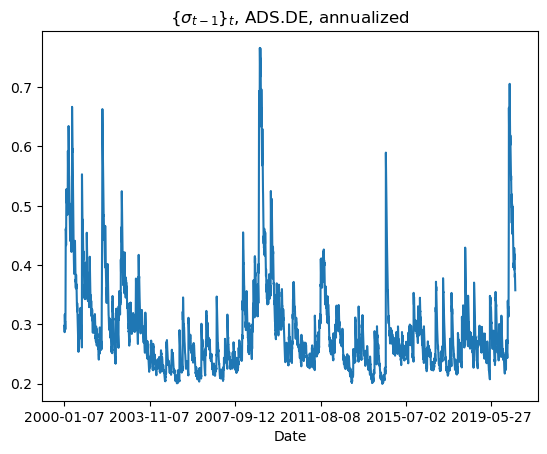

In [23]:
sigma_t.plot()
plt.title('$\{\sigma_{t-1}\}_t$, ADS.DE, annualized')
plt.show()

**Python Package for MLE**

our notation: ARMA(p,q) GARCH(m,s)

this package: AR(lags) GARCH(p,q)

In [5]:
ar_garchmodel = arch_model(r_t, mean='AR', lags=2, vol='GARCH', p=1, q=1, dist='normal', rescale=False)
ar_garchmodel_fit = ar_garchmodel.fit()
ar_garchmodel_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 51673878150.70922
Iteration:      2,   Func. Count:     23,   Neg. LLF: 15480297.972322809
Iteration:      3,   Func. Count:     37,   Neg. LLF: 13808387.020244274
Iteration:      4,   Func. Count:     51,   Neg. LLF: 10389238.846153555
Iteration:      5,   Func. Count:     65,   Neg. LLF: 1.9604766687606538e+17
Iteration:      6,   Func. Count:     82,   Neg. LLF: 197055806.50664514
Iteration:      7,   Func. Count:     96,   Neg. LLF: 38575952187891.11
Iteration:      8,   Func. Count:    112,   Neg. LLF: -13800.528894340478
Optimization terminated successfully    (Exit mode 0)
            Current function value: -13800.528886786944
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 ADS.DE   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:                13800.5
Distribution:                  Normal   AIC:                          -27589.1
Method:            Maximum Likelihood   BIC:                          -27549.6
                                        No. Observations:                 5283
Date:                Thu, Jun 19 2025   Df Residuals:                     5280
Time:                        16:36:24   Df Model:                            3
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const      1.0633e-03  2.316e-04      4.591  4.404e-06   [6.094e-04,1.517e-03]
ADS.DE[1]      0.0340  1.475e-02      2.306  2.109e-02   [5.111e-03,6.294e-02]
ADS.DE[2]     -0.0416  9.720e-03     -4.282  1.853e-05 [-6.067e-02,-2.257e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.3174e-06  8.252e-11  8.867e+04      0.000 [7.317e-06,7.318e-06]
alpha[1]       0.0500  1.190e-02      4.201  2.659e-05 [2.667e-02,7.333e-02]
beta[1]        0.9300  1.106e-02     84.107      0.000     [  0.908,  0.952]
============================================================================

Covariance estimator: robust
"""